In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim

# from torch.optim.lr_scheduler import _LRScheduler
from torch import optim
import torch.utils.data as data

# import timm
# from timm.optim import optim_factory
# from types import SimpleNamespace

# from efficientnet_pytorch import EfficientNet

import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torchvision.models as models

# from sklearn import decomposition
# from sklearn import manifold
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import numpy as np

# import copy
import random
import time

import pandas as pd
# from PIL import Image

from skimage import io as skio, transform
import cv2
import math

import re

from utils import export_report
from nn_modules import ThreePagesEffModule

import mlflow
import mlflow.sklearn

from urllib.parse import urlparse

In [2]:
#Experiment Setup
DATA = 'tobacco800'
INPUT_DIM = 3
OUTPUT_DIM = 4
OUTPUT_METRIC = 2
NN = 'effnetB0'
PRE_PROCESS = ''
POS_PROCESS = ''
FINETUNNING = 'Layer11'
EXPERIMENT = f'{DATA}_input_{INPUT_DIM}_classes_{OUTPUT_DIM}_nn_{NN}'
if PRE_PROCESS != '':
    EXPERIMENT += f'_PRE_{PRE_PROCESS}'
if POS_PROCESS != '':
    EXPERIMENT += f'_POS_{POS_PROCESS}'
if FINETUNNING != '':
    EXPERIMENT += f'_FT_{FINETUNNING}'
print(EXPERIMENT)

SEED = 1234
FOUND_LR = 5e-3

tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11


In [3]:
# Load data
PAGE_IMGS_PATH = '/home/fellipe/Documentos/AI.Lab/artificial-intelligence/segmentation_pages/data_files/SinglePageTIF/'
TRAIN_LABEL_PATH = '/home/fellipe/Documentos/AI.Lab/artificial-intelligence/segmentation_pages/data_files/train.csv'
TEST_LABEL_PATH = '/home/fellipe/Documentos/AI.Lab/artificial-intelligence/segmentation_pages/data_files/test.csv'

MODEL_PATH = '/home/fellipe/Documentos/AI.Lab/artificial-intelligence/segmentation_pages/model/'

In [4]:
def set_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

In [5]:
def define_model():
  return ThreePagesEffModule(OUTPUT_DIM, False, 14)

In [6]:
pretrained_size = (224,224)
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

class ResizeBinarize(object):
    def __call__(self, image):
        if len(image.shape)>2:
            image=image[0,:,:]
        resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_CUBIC)
        retval,bin = cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return bin

def data_processing():
  return transforms.Compose([
                            ResizeBinarize(),
                            #transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
                            #transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                       ])

In [7]:
def get_docid_radical_and_page(row):
    match = re.match(r"^([a-zA-Z0-9\-]*)(_(\d+))?$",row['docid'])
    if match:
        #print(match.groups()[0])
        row['radical'] = match.groups()[0]
        row['page'] = int(match.groups()[2]) if match.groups()[2] else 1
    else:
        print('error', row)
    return row

def get_extended_class(x):
    page = x['page'] 
    pages = x['pages']
    if pages == 1: 
        x['extended_class'] = 'single page'
        return x
    if page == 1:
        x['extended_class'] = 'first of many'
        return x
    if page == pages:
        x['extended_class'] = 'last page'
        return x
    x['extended_class'] = 'middle'
    return x

In [8]:
def add_extended_class_column(df):
    df = df.apply(get_docid_radical_and_page, axis=1)
    df_aux = df.groupby(['radical'], as_index=False)[['page']].max()
    df_aux.rename(columns={'page':'pages'}, inplace=True)
    df = df.merge(df_aux, how='left', on='radical')
    df = df.apply(get_extended_class, axis=1)
    return df.copy()

In [9]:
class ThreePagesTobaccoDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, dataframe, root_dir, label2Idx, transform=None):
        self.dataframe = dataframe
        self.root_dir=root_dir
        self.transform = transform
        self.label2Idx = label2Idx

    def __len__(self):
        return len(self.dataframe)
    
    def get_page_file_name_label(self, index, transform, target):
        if index < 0 or index >= len(self.dataframe):
            page = np.full_like(target, 255)
            file_name = None
            label = None
        else:     
            row = self.dataframe.iloc[index]
            file_name = row["docid"]+'.tif'
            page = skio.imread(self.root_dir+file_name,plugin='pil')
            label = row['extended_class']
        if transform:
            page = transform(page)
        return page, file_name, label

    def __getitem__(self, index):
        if type(index) != int:
            i = index.item()
        else: i = index
            
        row = self.dataframe.iloc[index]
        file_name = row["docid"]+'.tif'
        target_page = skio.imread(self.root_dir+file_name,plugin='pil')
        label = row['extended_class']        
        
        if index < 1:
            next_row = self.dataframe.iloc[index+1]
            prev_page = np.full_like(target_page, 255)
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')
        elif index >= len(self.dataframe) - 1:
            prev_row = self.dataframe.iloc[index-1]
            next_page = np.full_like(target_page, 255)
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
        else:
            prev_row = self.dataframe.iloc[index-1]
            next_row = self.dataframe.iloc[index+1]
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')            
                    
        if self.transform:
            target_page = self.transform(target_page)
            prev_page = self.transform(prev_page)
            next_page = self.transform(next_page)
            
        return (
            [prev_page, target_page, next_page],
            self.label2Idx[label],
            file_name
        )

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def concat_images(imga, imgb, imgc):
    """
    Combines three color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    hc,wc = imgc.shape[:2]
    max_height = np.max([ha, hb, hc])
    total_width = wa+wb+wc
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    new_img[:hc,wa+wb:wa+wb+wc]=imgc
    return new_img 

def plot_images(images, labels, classes, file_names, normalize = True):

    n_images = len(labels)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        
        prev_image = images[i][0]
        curr_image = images[i][1]
        next_page = images[i][2]

        ax = fig.add_subplot(rows, cols, i+1)
        
        if normalize:
            prev_image = normalize_image(prev_image)
            curr_image = normalize_image(curr_image)
            next_page = normalize_image(next_page)

        prev_image = prev_image.permute(1, 2, 0).cpu().numpy()    
        curr_image = curr_image.permute(1, 2, 0).cpu().numpy()
        next_page = next_page.permute(1, 2, 0).cpu().numpy()

        ax.imshow(concat_images(prev_image, curr_image, next_page))
        ax.set_title(f'{classes[labels[i]]}\n' \
                     f'{file_names[i]}')   
        ax.axis('off')

In [11]:
def config_params(model):
  params = [
            {'params': model.base_model.parameters(), 'lr': FOUND_LR / 10},
            {'params': model.classifier.parameters()}
          ]

  optimizer = optim.Adam(params, lr = FOUND_LR)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  criterion = nn.CrossEntropyLoss()

  model = model.to(device)
  criterion = criterion.to(device)

  return params, optimizer, scheduler, device, criterion, model

In [12]:
def calculate_accuracy(y_pred, y): 
    correct = y_pred.eq(y.view_as(y_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [13]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_2 = 0
    epoch_kappa = 0
    epoch_kappa_2 = 0
    
    model.train()
    
    for (x, y, name) in iterator:
        
        x1, x2, x3 = x
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x1, x2, x3)
        
        loss = criterion(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        acc = calculate_accuracy(top_pred, y)
        acc_2 = calculate_accuracy(torch.div(top_pred, 2, rounding_mode='floor'), torch.div(y, 2, rounding_mode='floor'))

        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
        kappa_2 = cohen_kappa_score((torch.div(y, 2, rounding_mode='floor')).tolist(), torch.div(top_pred.flatten().cpu(), 2, rounding_mode='floor'))

        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_acc_2 += acc_2.item()
        epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        epoch_kappa_2 += 1.0 if math.isnan(kappa_2) else kappa_2
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator), epoch_acc_2 / len(iterator), epoch_kappa_2 

In [14]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_2 = 0
    epoch_kappa = 0
    epoch_kappa_2 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y, _) in iterator:
            
            x1, x2, x3 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)            
            y = y.to(device)

            y_pred = model(x1, x2, x3)

            loss = criterion(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)

            acc = calculate_accuracy(top_pred, y)
            acc_2 = calculate_accuracy(torch.div(top_pred, 2, rounding_mode='floor'), torch.div(y, 2, rounding_mode='floor'))

            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
            kappa_2 = cohen_kappa_score((torch.div(y, 2, rounding_mode='floor')).tolist(), torch.div(top_pred.flatten().cpu(), 2, rounding_mode='floor'))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_acc_2 += acc_2.item()
            epoch_kappa += 1.0 if math.isnan(kappa) else kappa
            epoch_kappa_2 += 1.0 if math.isnan(kappa_2) else kappa_2
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator), epoch_acc_2 / len(iterator), epoch_kappa_2 / len(iterator) 

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
def get_predictions(model, iterator, device):

    model.eval()

    prev_page_images = []
    curr_page_images = []
    next_page_images = []
    
    labels = []
    probs = []
    file_names = []

    with torch.no_grad():

        for (x, y, name) in iterator:

            prev_page, curr_page, next_page = x
            prev_page = prev_page.to(device)
            curr_page = curr_page.to(device)
            next_page = next_page.to(device)
            
            y_pred = model(prev_page, curr_page, next_page)
            
            #concat_images(prev_page.cpu(), curr_page.cpu(), next_page.cpu())

            prev_page_images.append(prev_page.cpu())
            curr_page_images.append(curr_page.cpu())
            next_page_images.append(next_page.cpu())
            labels.append(torch.div(y.cpu(), 2, rounding_mode='floor'))
            probs.append(y_pred.cpu())
            file_names.append(name)

    prev_page_images = torch.cat(prev_page_images, dim = 0)
    curr_page_images = torch.cat(curr_page_images, dim = 0)
    next_page_images = torch.cat(next_page_images, dim = 0)    
    
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    file_names = list(sum(file_names, ()))

    return [prev_page_images, curr_page_images, next_page_images] , labels, probs, file_names


### main()

Loaded pretrained weights for efficientnet-b0
Number of training examples: 831
Number of validation examples: 200
Number of test examples: 259
Winner Epoch: 01.
Epoch: 01 | Epoch Time: 3m 5s
	Train Loss: 1.362 | Train Acc: 41.30% | Train Kappa: 18.34% | Train Acc 2: 62.73% | Train Kappa 2: 525.18%
	 Val. Loss: 1.385 |  Val. Acc: 30.36% |  Val. Kappa: 3.37% |  Val. Acc 2: 51.79% |  Val. Kappa 2: 6.21%
Epoch: 02 | Epoch Time: 3m 15s
	Train Loss: 1.230 | Train Acc: 66.91% | Train Kappa: 52.20% | Train Acc 2: 78.23% | Train Kappa 2: 1391.63%
	 Val. Loss: 1.386 |  Val. Acc: 27.68% |  Val. Kappa: 6.06% |  Val. Acc 2: 54.46% |  Val. Kappa 2: 9.72%
Winner Epoch: 03.
Epoch: 03 | Epoch Time: 3m 20s
	Train Loss: 1.103 | Train Acc: 74.98% | Train Kappa: 64.67% | Train Acc 2: 84.73% | Train Kappa 2: 1789.71%
	 Val. Loss: 1.381 |  Val. Acc: 32.59% |  Val. Kappa: 12.98% |  Val. Acc 2: 57.59% |  Val. Kappa 2: 14.82%
Winner Epoch: 04.
Epoch: 04 | Epoch Time: 3m 22s
	Train Loss: 0.993 | Train Acc: 84.60

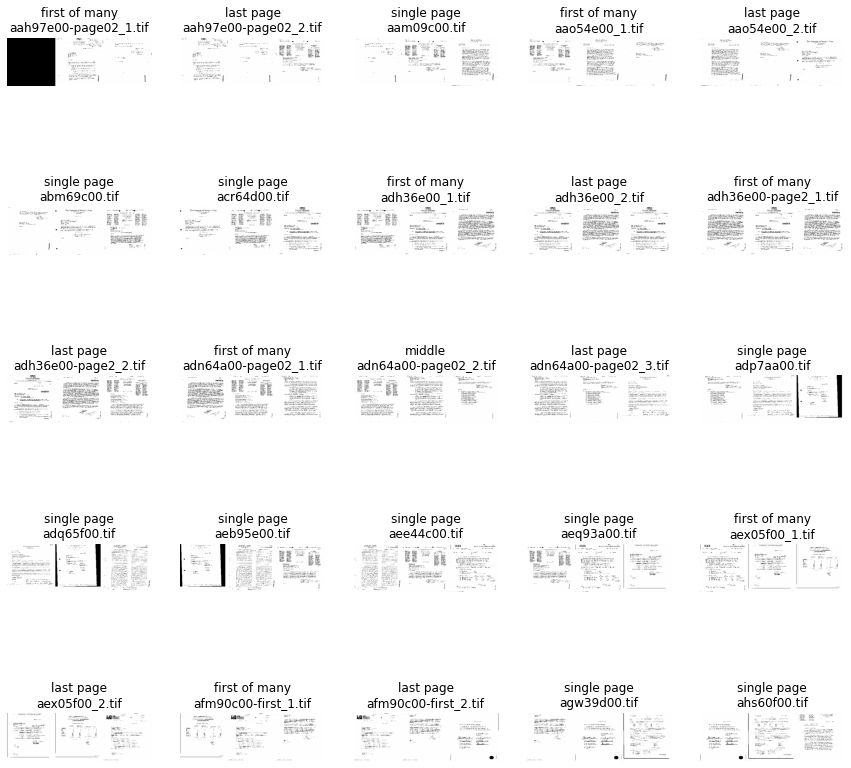

In [17]:
set_seeds()
model = define_model()
transform = data_processing()

df_train = pd.read_csv(TRAIN_LABEL_PATH, sep=';', skiprows=0, low_memory=False)
df_test = pd.read_csv(TEST_LABEL_PATH,sep=';', skiprows=0, low_memory=False)
df_val = df_train.iloc[-200:,:]
len(df_train),len(df_val), len(df_test)

df_train = add_extended_class_column(df_train)
df_test = add_extended_class_column(df_test)

df_val = df_train.iloc[-200:,:]
df_train = df_train.iloc[:-200,:]

label2Idx = {'single page': 3,'first of many': 2,'middle': 1,'last page':0}

train_data = ThreePagesTobaccoDataset(df_train,PAGE_IMGS_PATH, label2Idx, transform )
valid_data = ThreePagesTobaccoDataset(df_val,PAGE_IMGS_PATH, label2Idx, transform )
test_data = ThreePagesTobaccoDataset(df_test,PAGE_IMGS_PATH, label2Idx, transform )

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_data)}')

N_IMAGES = 25
images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                          [train_data[i] for i in range(N_IMAGES)]])
classes = {3: 'single page',2: 'first of many',1:'middle',0:'last page'}
#prev_images, curr_images = images[0]
plot_images(images, labels, classes, file_names)

BATCH_SIZE = 32
train_iterator = data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

params, optimizer, scheduler, device, criterion, model = config_params(model)

EPOCHS = 20
best_valid_loss = float('inf')
experiment_data = []

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa, train_acc_2, train_kappa_2 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa, valid_acc_2, valid_kappa_2 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print (f'Winner Epoch: {epoch+1:02}.')
        torch.save(model.state_dict(), MODEL_PATH + EXPERIMENT + '.pt')

    scheduler.step(valid_loss)
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}% | Train Acc 2: {train_acc_2*100:.2f}% | Train Kappa 2: {train_kappa_2*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}% |  Val. Acc 2: {valid_acc_2*100:.2f}% |  Val. Kappa 2: {valid_kappa_2*100:.2f}%')

    experiment_data.append([train_loss, valid_loss, train_acc, valid_acc, train_kappa, valid_kappa, train_acc_2, valid_acc_2, train_kappa_2, valid_kappa_2, start_time, end_time])
    experiment_df = pd.DataFrame(experiment_data,columns=['train_loss','valid_loss','train_acc', 'valid_acc','train_kappa', 'valid_kappa', 'train_acc_2', 'valid_acc_2', 'train_kappa_2', 'valid_kappa_2', 'start', 'end' ])
    experiment_df.to_pickle(MODEL_PATH + EXPERIMENT+ '.pk')

experiment_df = pd.read_pickle(MODEL_PATH + EXPERIMENT + '.pk')

print(EXPERIMENT)
print(experiment_df.sort_values(by=['valid_loss']).iloc[0])
train_loss, valid_loss, train_acc,valid_acc,test_kappa,valid_kappa,train_acc_2,valid_acc_2,train_kappa_2,valid_kappa_2,start,end = experiment_df.sort_values(by=['valid_loss']).iloc[0]

model.load_state_dict(torch.load(MODEL_PATH + EXPERIMENT + '.pt'))
test_loss, test_acc, test_kappa, test_acc_2, test_kappa_2 = evaluate(model, test_iterator, criterion, device)
print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% |  Val. Kappa: {test_kappa*100:.2f}% |  Val. Acc 2: {test_acc_2*100:.2f}% |  Val. Kappa 2: {test_kappa_2*100:.2f}%')

images, labels, probs, file_names = get_predictions(model, test_iterator, device)
pred_labels = torch.div(torch.argmax(probs, 1), 2, rounding_mode='floor')

classes = {'NextPage':0, 'FirstPage':1}

def report():
  report_file_path = './report_final.json'
  return export_report(EXPERIMENT, 
              labels, 
              pred_labels, 
              list(classes.keys()),
              valid_loss, 
              valid_acc_2, 
              valid_kappa_2,               
              test_loss, 
              test_acc_2, 
              test_kappa_2, 
              report_file_path)
  
report = report()

In [20]:
mlflow.sklearn.autolog()

In [28]:
def report():
  report_file_path = './report_final.json'
  return export_report(EXPERIMENT, 
              labels, 
              pred_labels, 
              list(classes.keys()),
              valid_loss, 
              valid_acc_2, 
              valid_kappa_2,               
              test_loss, 
              test_acc_2, 
              test_kappa_2, 
              report_file_path)
  
report = report()

{'tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11': {'NextPage': {'precision': 0.8125, 'recall': 0.7358490566037735, 'f1-score': 0.7722772277227722, 'support': 106}, 'FirstPage': {'precision': 0.8282208588957055, 'recall': 0.8823529411764706, 'f1-score': 0.8544303797468354, 'support': 153}, 'accuracy': 0.8223938223938224, 'macro avg': {'precision': 0.8203604294478528, 'recall': 0.8091009988901221, 'f1-score': 0.8133538037348038, 'support': 259}, 'weighted avg': {'precision': 0.8217868394248762, 'recall': 0.8223938223938224, 'f1-score': 0.8208078542080297, 'support': 259}, 'valid_acc': 0.7901785714285714, 'valid_kappa': 0.5824676921503539, 'test_acc': 0.8402777777777778, 'test_kappa': 0.6620742667913581}}


In [29]:
print(report)

{'tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11': {'NextPage': {'precision': 0.8125, 'recall': 0.7358490566037735, 'f1-score': 0.7722772277227722, 'support': 106}, 'FirstPage': {'precision': 0.8282208588957055, 'recall': 0.8823529411764706, 'f1-score': 0.8544303797468354, 'support': 153}, 'accuracy': 0.8223938223938224, 'macro avg': {'precision': 0.8203604294478528, 'recall': 0.8091009988901221, 'f1-score': 0.8133538037348038, 'support': 259}, 'weighted avg': {'precision': 0.8217868394248762, 'recall': 0.8223938223938224, 'f1-score': 0.8208078542080297, 'support': 259}, 'valid_acc': 0.7901785714285714, 'valid_kappa': 0.5824676921503539, 'test_acc': 0.8402777777777778, 'test_kappa': 0.6620742667913581}}


In [30]:
with mlflow.start_run():
  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  mlflow.log_param('DATA', DATA)
  mlflow.log_param('INPUT_DIM', INPUT_DIM)
  mlflow.log_param('OUTPUT_DIM', OUTPUT_DIM)
  mlflow.log_param('OUTPUT_METRIC', OUTPUT_METRIC)
  mlflow.log_param('NN', NN)
  mlflow.log_param('FINETUNNING', FINETUNNING)
  mlflow.log_param('SEED', SEED)
  mlflow.log_param('N_IMAGES', N_IMAGES)
  mlflow.log_param('BATCH_SIZE', BATCH_SIZE)
  mlflow.log_param('FOUND_LR', FOUND_LR)
  mlflow.log_param('EPOCHS', EPOCHS)
  mlflow.log_metric('val_loss', test_loss)
  mlflow.log_metric('val_acc', test_acc)
  mlflow.log_metric('val_kappa', test_kappa)
  mlflow.log_metric('val_acc_2', test_acc_2)
  mlflow.log_metric('val_kappa_2', test_kappa_2)
  mlflow.log_metric('train_loss', train_loss)
  mlflow.log_metric('valid_loss', valid_loss)
  mlflow.log_metric('train_acc', train_acc)
  mlflow.log_metric('valid_acc', valid_acc)
  mlflow.log_metric('train_kappa', train_kappa)
  mlflow.log_metric('valid_kappa', valid_kappa)
  mlflow.log_metric('train_acc_2', train_acc_2)
  mlflow.log_metric('valid_acc_2', valid_acc_2)
  mlflow.log_metric('train_kappa_2', train_kappa_2)
  mlflow.log_metric('valid_kappa_2', valid_kappa_2)
  mlflow.log_metric('start', start)
  mlflow.log_metric('end', end)


#   data_report = report[next(iter(report))]
  print('DATA_REPORT:')
  print(EXPERIMENT)
  mlflow.log_params(report[EXPERIMENT])

  # Model registry does not work with file store
  if tracking_url_type_store != "file":

      # Register the model
      # There are other ways to use the Model Registry, which depends on the use case,
      # please refer to the doc for more information:
      # https://mlflow.org/docs/latest/model-registry.html#api-workflow
      mlflow.sklearn.log_model(model, "model", registered_model_name="SegmentationPage")
  else:
      mlflow.sklearn.log_model(model, "model")

DATA_REPORT:
tobacco800_input_3_classes_4_nn_effnetB0_FT_Layer11
